In [1]:
import socket

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((socket.gethostname(), 2024))
s.listen(5)
socket.gethostname()

'MSI'

In [2]:
import numpy as np
import tensorflow as tf

# Load the trained model
#!pip install tensorflow==2.15.0

def custom_loss(y_true, y_pred):
    #Standard Mean Squared Error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    #Penalty for predictions outside the range [-25, 25]
    penalty_lower = tf.square(tf.minimum(y_pred + 25, 0)) # Penalize for values below -25
    penalty_upper = tf.square(tf.maximum(y_pred - 25, 0)) # Penalize for values above 25
    #Total penalty
    penalty = tf.reduce_mean(penalty_lower + penalty_upper)
    # Return the combined loss (MSE + penalty)
    return mse + penalty

regression_model = tf.keras.models.load_model('E:\Jenish\Python\MyoConnect\\torque_prediction_model.h5', custom_objects={'custom_loss': custom_loss})


In [3]:
input = np.zeros([1, 12])

feature = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]])#.reshape([1, 12])

T = regression_model.predict(feature.reshape([1, 12]))[0][0]
T

1/1 [==============================] - 0s 86ms/step


1.14082

In [47]:
clientsocket, address = s.accept()
clientsocket.send(bytes("connected", "utf-8"))
print(address)

Data = []
Info = []
t_prev, q_prev = 0, 0
i = 0# for i in range(10000):
while True:
    msg = clientsocket.recv(128).decode("utf-8").split(";")[0].split(',')

    try:
        t, q, w = float(msg[0]), float(msg[1]), float(msg[2])
        if t!=0: 
            # Data.append([i, t, q, w])

            q = q*np.pi/180
            dt = t - t_prev
            if dt==0: continue
            dq = q - q_prev
            v= dq/dt
            t_prev, q_prev = t, q
            print(t, end='\r')

            # ML prediction
            feature = np.delete(feature, (0), axis=0)
            feature = np.vstack([feature, [q, v, T]])
            T = regression_model.predict(feature.reshape([1, 12]), verbose=0)[0][0]

            # send data to exo
            print(clientsocket.send(bytes(f" {t*1000},{int(T*1000)}", "utf-8")), end="  ")
            print(msg, end='\r')

            Info.append([t, q, v, T])

    except: pass
    i+=1

# check tensorflow is running on GPU
# compile it as C++ executable
# implement filter to remove spikes in predicted torque (will add additional delay)
# 
# 

('172.16.0.1', 45840)


ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [28]:
!nvidia-smi

Wed Sep 11 12:09:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             24W /  115W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
import numpy as np
import matplotlib.pyplot as plt
# Info = np.array(Info)3
Path = "E:\Jenish\Python\Live-ML-Data-240915-1154-final.npy"
Info = np.load(Path)
len(Info), Info[0]

(2743,
 array([ 8.41500000e+01,  1.92753208e+00,  2.29059071e-02, -2.83578306e-01]))

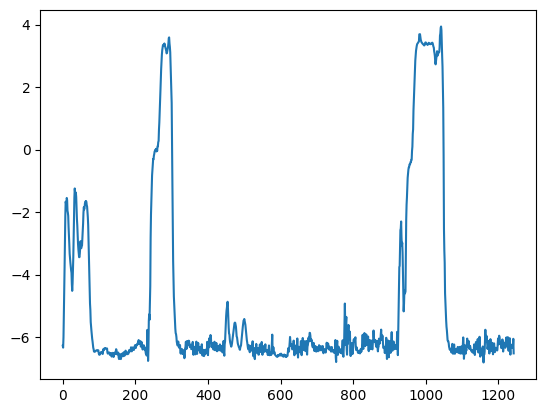

In [42]:
# plt.plot(Info.T[1][100:])
# plt.plot(Info.T[2][100:])
plt.plot(Info.T[3][1500:3800])

In [12]:
import numpy as np
import matplotlib.pyplot as plt 

# Data = np.array(Info)
Info = np.load("E:\Jenish\Python\Live-ML-Data-240911-2228.npy")

In [13]:
Info # time, q, v, T

array([[ 2.00000000e-02,  3.13784299e-01,  1.56892149e+01,
         2.19366360e+00],
       [ 7.00000000e-02,  3.13784299e-01,  0.00000000e+00,
        -3.99385542e-01],
       [ 1.30000000e-01,  3.13784299e-01,  0.00000000e+00,
         5.25054884e+00],
       ...,
       [ 2.81450000e+02,  4.18094984e-01, -1.53397861e-01,
         3.03980231e+00],
       [ 2.81610000e+02,  4.24230916e-01,  3.83495742e-02,
         3.04286599e+00],
       [ 2.81650000e+02,  4.19628971e-01, -1.15048614e-01,
         3.01658201e+00]])

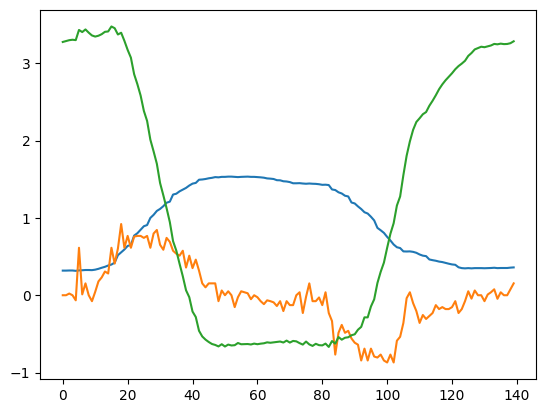

In [35]:
Data = Info[4120:4260]
plt.plot(Data.T[1], label="")
plt.plot(Data.T[2])
plt.plot(Data.T[3])
plt.legend()

In [40]:
import numpy as np
import scipy.io

filename = "E:\Jenish\Python\Live-ML-Data-240915-0907-final"
Info = np.load(f"{filename}.npy")
scipy.io.savemat(f'{filename}.mat', {"Data0":Info})